In [ ]:
import os,sys, importlib, numpy as np
import matplotlib.pyplot as plt
import jpcm
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# user=os.popen('whoami').read().replace('\n','')
user='mitt-wsl'
print(f'User: {user}')
modelname = "rBERT"
preprocessor = "control"
model = f"{modelname}/{preprocessor}/" #WV_0_PC_0_EH_0_PS_1

spec = importlib.util.spec_from_file_location("module.name", f'./user/{user}_param.py')
userparam = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = userparam
spec.loader.exec_module(userparam)

checkpoint_dir = userparam.param['model_dir']

result_path = f"{checkpoint_dir}/{model}/test_result/"

In [ ]:
gt = np.load(f'{result_path}true_data.npy'.replace('/mnt/c','C:'))
pd = np.load(f'{result_path}pred_data.npy'.replace('/mnt/c','C:'))

In [ ]:
print(gt.shape)
print(pd.shape)

KeyboardInterrupt: 

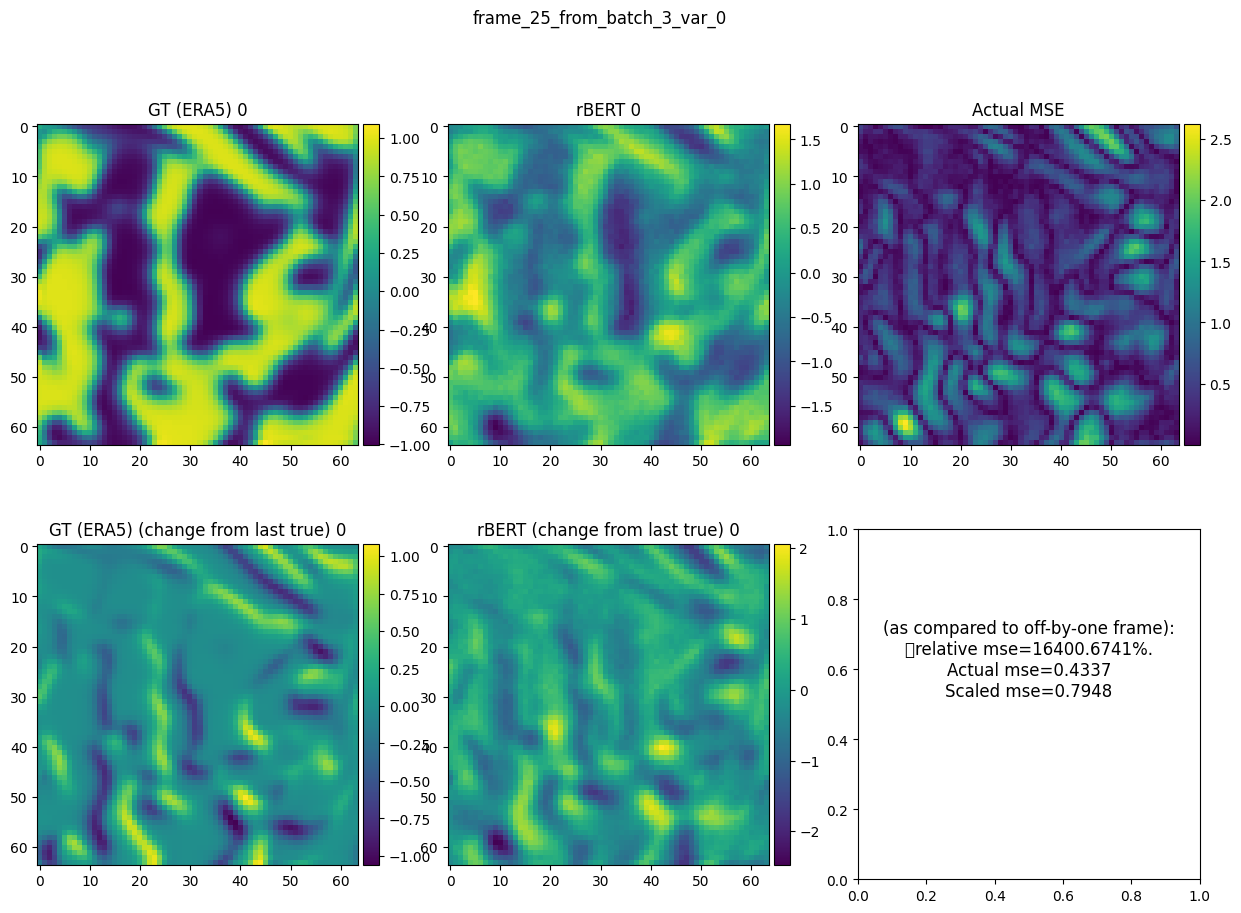

In [6]:
# stepi = 5
# var_dicts = {0:'u wind', 1:'v wind', 2:'Sea Surface Temperature',
#             3:'Surface Pressure', 4:'Precipitation'}
# var_dicts = {0:'-',}
shift = gt.shape[2] - pd.shape[2]
# var = 0
# b = 4 # BATCH
# a = 3 # MINIBATCH
# stepi =34

bs = gt.shape[0] * gt.shape[1]
bts = np.arange(0,bs-0.9,3).astype(int)
sps = [5,25,30,38]

variables = gt.shape[3]
for var in range(variables):
    for bq in bts:
        b = bq // gt.shape[1]
        a = bq % gt.shape[1]
        for stepi in sps:

            stepd = 19 # last true frame

            fig, axs = plt.subplots(2,3, figsize=(15,10))
            ax0 = axs[0,0]
            im0 = ax0.imshow(gt[b,a,shift+stepi,var,:,:])
            divider = make_axes_locatable(ax0)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im0, cax=cax, orientation='vertical')
            ax0.set_title(f'GT (ERA5) {var}')
            ax1 = axs[0,1]
            im1 = ax1.imshow(pd[b,a,stepi,var,:,:])
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im1, cax=cax, orientation='vertical')
            ax1.set_title(f'{modelname} {var}')


            ax0 = axs[1,0]
            im0 = ax0.imshow(gt[b,a,shift+stepi,var,:,:]-gt[b,a,shift+stepd,var,:,:])
            divider = make_axes_locatable(ax0)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im0, cax=cax, orientation='vertical')
            ax0.set_title(f'GT (ERA5) (change from last true) {var}')

            ax1 = axs[1,1]
            im1 = ax1.imshow((pd[b,a,stepi,var,:,:]-pd[b,a,stepd,var,:,:]))
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im1, cax=cax, orientation='vertical')
            ax1.set_title(f'{modelname} (change from last true) {var}')

            ax2 = axs[0,2]
            d = gt[b,a,shift+stepi,var,:,:]-pd[b,a,stepi,var,:,:]
            d0 = gt[b,a,shift+stepi+1,var,:,:]-gt[b,a,shift+stepi,var,:,:]
            im2 = ax2.imshow(np.abs(d))
            divider = make_axes_locatable(ax2)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im2, cax=cax, orientation='vertical')
            mse = np.mean(d**2)
            relmse = mse / np.mean(gt[b,a,shift+stepi,var,:,:]**2)
            meanMse = mse*100 / np.mean(d0**2)
            # medianMse = np.median(d**2)*100 / np.median(d0**2)
            ax2.set_title('Actual MSE')
            ax3 = axs[1,2]
            ax3.set_title(f'(as compared to off-by-one frame):\n\trelative mse={meanMse:.4f}%.\nActual mse={mse:.4f}\nScaled mse={relmse:.4f}', \
                y=0.5)
            nm = f'frame_{stepi}_from_batch_{b*gt.shape[1] + a}_var_{var}'
            plt.suptitle(nm)
            plt.savefig(f'{result_path}{nm}.png'.replace('/mnt/c','C:'))
            plt.close()
            # plt.show()

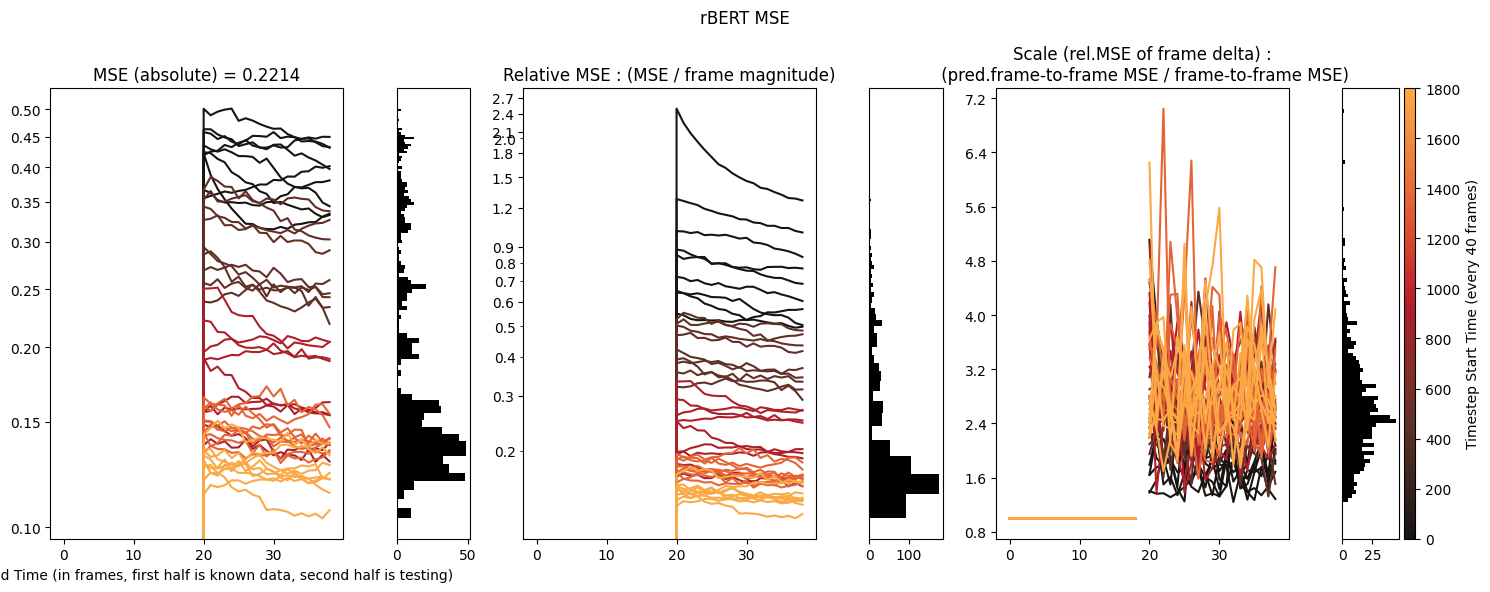

In [73]:
import matplotlib.ticker as mticker
total_length = gt.shape[2]
input_length = 20

# fig,axs = plt.subplots(1,6, figsize=(15,6))
fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(1, 6,  width_ratios=(4, 1,4,1,4,1))
axs = []
for i in range(3):
    axs.append(fig.add_subplot(gs[0, 2*i]))
    axs.append(fig.add_subplot(gs[0, 2*i+1], sharey=axs[-1]))
cmap = jpcm.get('desert')
cs = cmap.resampled(gt.shape[0]).colors
avg = 0.0
ravg = 0.0
k = 0
allmeans = []
allrelmeans = []
allspmeans = []
for ba in range(gt.shape[0]*gt.shape[1]): # for each batch (i.e. each general section of time)
    b = ba // gt.shape[1]
    a = ba % gt.shape[1]
    means = []
    relMeans = []
    spMeans = []
    for f in range(gt.shape[2]-shift-1): # for each frame (i.e. each time step in the batch)
        d = gt[b,a,shift+f,var,:,:]-pd[b,a,f,var,:,:]
        g = gt[b,a,shift+f,var,:,:]
        g0 = gt[b,a,shift+f+1,var,:,:]-gt[b,a,shift+f,var,:,:]
        d0 = pd[b,a,f+1,var,:,:]-pd[b,a,f,var,:,:]
        meanMse = np.mean(d**2)
        # meanShiftMse = np.mean(d0**2)
        meang = np.mean(g**2)
        means.append(meanMse)
        relMeans.append(meanMse/meang)
        spMeans.append(np.mean(d0**2) / np.mean(g0**2))

    axs[0].plot(means, color=cs[b], label=f'Timestep Batch {b}')
    axs[2].plot(relMeans, color=cs[b], label=f'Timestep Batch {b}')
    spMeans[stepd] = np.nan
    axs[4].plot(spMeans, color=cs[b], label=f'Timestep Batch {b}')
    avg += np.mean(means)
    ravg += np.mean(relMeans)
    k+=1
    allmeans.extend(means)
    allrelmeans.extend(relMeans)
    allspmeans.extend(spMeans)
avg /= k
avg *= total_length/(total_length-input_length)
ravg /= k
ravg *= total_length/(total_length-input_length)
# plt.plot(medians, label='Median')
axs[0].set_xlabel('        Lead Time (in frames, first half is known data, second half is testing)')
axs[0].set_title(f'MSE (absolute) = {avg:.4f}')
axs[0].set_yscale('log')
axs[2].set_yscale('log')
# axs[2].set_yscale('log')
axs[2].set_title('Relative MSE : (MSE / frame magnitude)')
axs[4].set_title('Scale (rel.MSE of frame delta) :\n (pred.frame-to-frame MSE / frame-to-frame MSE)')
allmeansa = np.array(allmeans)
allmeansa = allmeansa[np.where(allmeansa > 0)]
allrelmeansa = np.array(allrelmeans)
allrelmeansa = allrelmeansa[np.where(allrelmeansa > 0)]
allspmeansa = np.array(allspmeans)
allspmeansa = allspmeansa[np.where(allspmeansa > 1)]
axs[1].hist(allmeansa, bins=100, color='k', orientation='horizontal')
axs[3].hist(allrelmeansa, bins=100, color='k', orientation='horizontal')
axs[5].hist(allspmeansa, bins=100, color='k', orientation='horizontal')


divider = make_axes_locatable(axs[5])
cax = divider.append_axes('right', size='20%', pad=0.05)
fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(0, gt.shape[0] * gt.shape[1] * gt.shape[2]), cmap=cmap
    ),
    cax=cax,
    orientation='vertical',
    label=f'Timestep Start Time (every {gt.shape[2]} frames)',
    # ticks=np.arange(0, gt.shape[0] * gt.shape[1] * gt.shape[2], gt.shape[2]).tolist(),
)
# plt.legend()/
[ax.yaxis.set_major_locator(plt.MaxNLocator(10)) for ax in axs[::2]]
[ax.yaxis.set_major_formatter(mticker.ScalarFormatter()) for ax in axs[::2]]
[ax.yaxis.set_minor_formatter(mticker.ScalarFormatter()) for ax in axs[::2]]
[ax.get_yaxis().set_visible(False) for ax in axs[1::2]]

plt.suptitle(f'{modelname} MSE')
plt.tight_layout()
plt.savefig(f'{result_path}mse.png'.replace('/mnt/c','C:'))
plt.show()

In [ ]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()
imd = pd.reshape(-1, *pd.shape[4:])


def animate(i):
    plt.clf()
    plt.imshow(imd[i])
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit']=1000000000
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=imd.shape[0], interval=100, )
ani

In [ ]:
ani.save(f'{result_path}animation.mp4'.replace('/mnt/c','C:'), writer='ffmpeg', fps=10)

skip the following:

In [ ]:
ss = np.std(pd[b,a,20:,var,:,:]-pd[b,a,19:-1,var,:,:] ,axis=(1,2)) **2   

In [ ]:
ss

In [ ]:
d = np.log(ss/ss[0])/np.log(2)
plt.plot(np.arange(1,20),d[1:])
plt.show()
plt.plot(np.arange(1,20),d[1:]-d[:-1])
plt.show()
d[1:]-d[:-1]

In [ ]:
ss = np.std(gt[b,a,:,var,:,:] ,axis=(1,2)) 

In [ ]:
np.log(ss[-1]/ss[0])